In [1]:
from mapd.visualization.visualization_tool import MAPDVisualizationTool

In [2]:
import dill as pickle

with open("probe_suite_ds.pkl", "rb") as f:
    probe_suite_dataset = pickle.load(f)

In [3]:
tool = MAPDVisualizationTool(mapd_loss_dataset_path="mapd_probes", probe_suite_dataset=probe_suite_dataset)

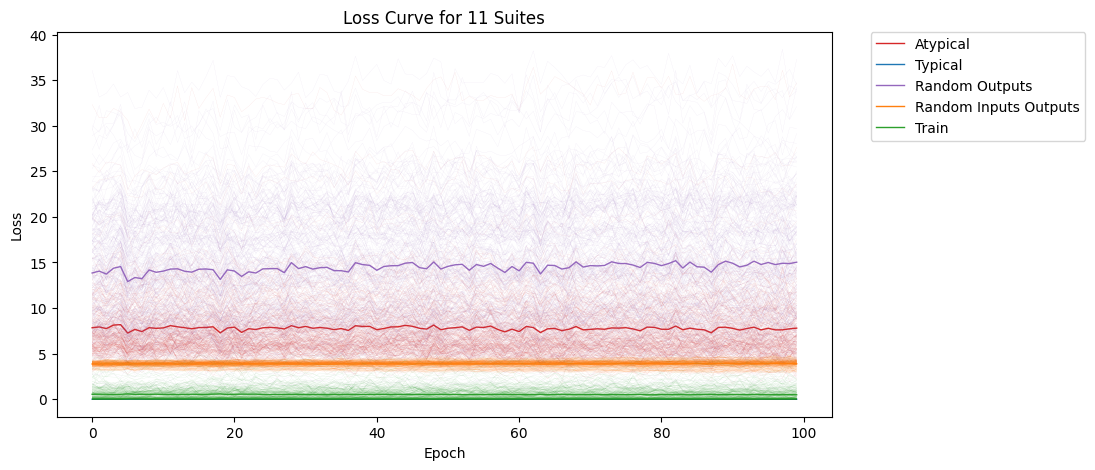

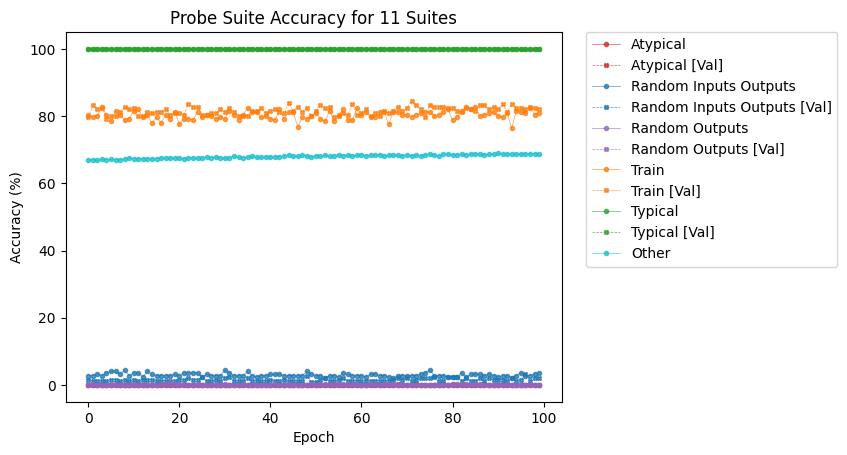

Epochs: 100%|██████████| 100/100 [00:50<00:00,  1.98it/s]


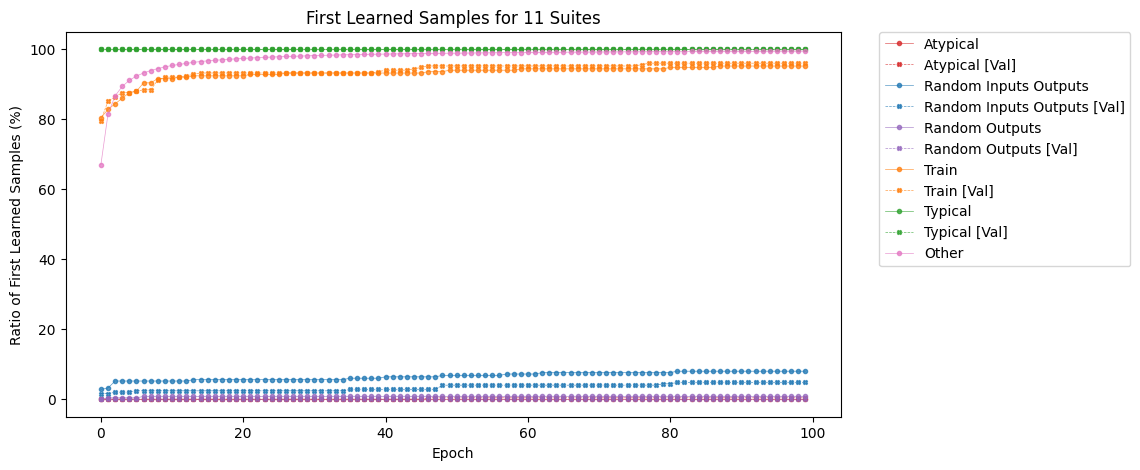

Computing consistently learned ratios...


Epochs: 100%|██████████| 100/100 [00:53<00:00,  1.86it/s]


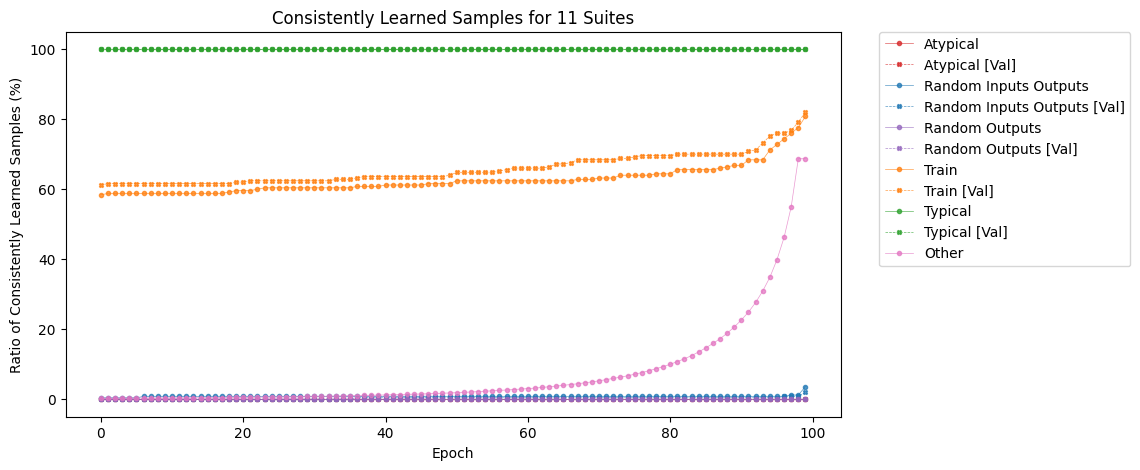

In [4]:
tool.all_plots()

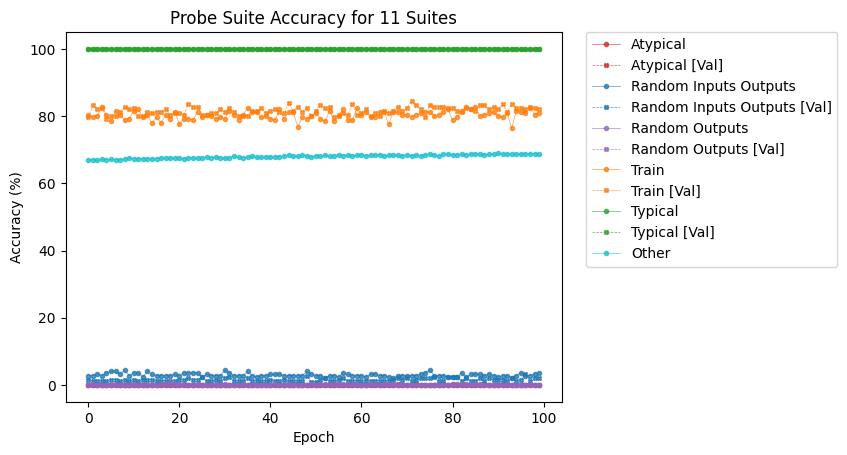

In [5]:
tool.probe_accuracy_plot()

Computing consistently learned ratios...


Epochs: 100%|██████████| 100/100 [00:50<00:00,  1.99it/s]


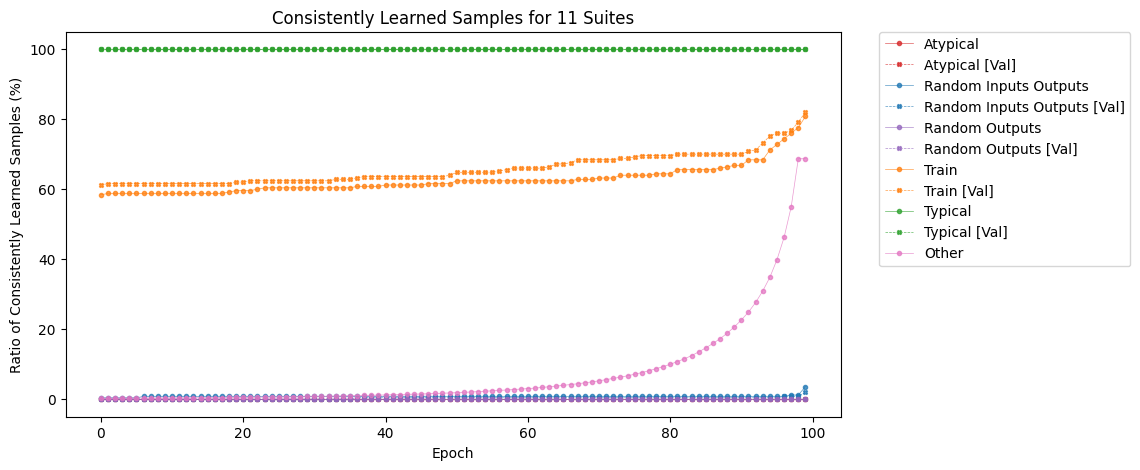

In [6]:
tool.consistently_learned_plot()

Epochs: 100%|██████████| 100/100 [00:46<00:00,  2.14it/s]


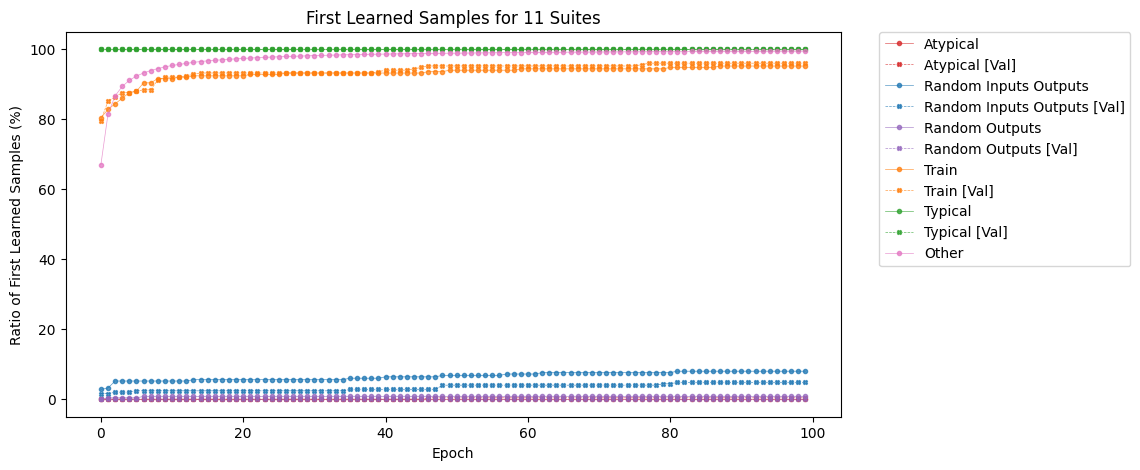

In [7]:
tool.first_learned_plot()

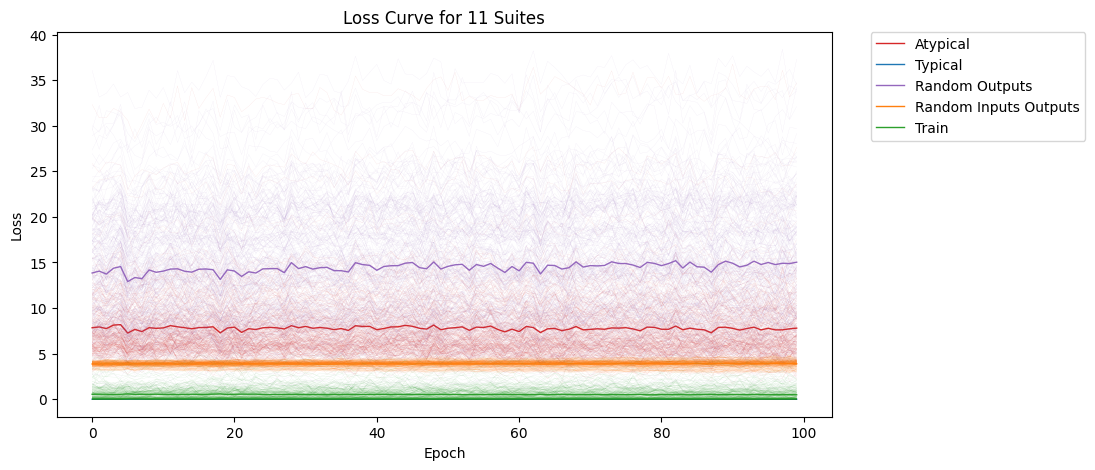

In [8]:
tool.loss_curve_plot()